In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import timedelta

# import data
[here](https://opendata.cabq.gov/dataset/vehicle-emissions/resource/2663c138-549e-4d55-932f-6aa549c7d158) is the MetaData


In [3]:
df_all = pd.read_csv('data/sample201320.csv', low_memory=False)

In [4]:
df_all.head(2)

,RecordID,RECORD_NUM,VIR_CERT_NUMBER,STATION_NUM,ANALYZER_NUM,INSPECTOR_NUM,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,VIN,VIN_SOURCE,VEH_LICENSE,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,ESC,VRT_RECORD_ID,E_TEST_SEQUENCE,E_PRECOND_PROCEDURE,E_HIGH_DCF,E_HIGH_RPM,E_HIGH_CO2,E_HIGH_O2,E_HIGH_HC,E_HIGH_HC_DCF,E_HIGH_HC_LIMIT,E_HIGH_CO,E_HIGH_CO_DCF,E_HIGH_CO_LIMIT,E_IDLE_DCF,E_IDLE_RPM,E_IDLE_CO2,E_IDLE_O2,E_IDLE_HC,E_IDLE_HC_DCF,E_IDLE_HC_LIMIT,E_IDLE_CO,E_IDLE_CO_DCF,E_IDLE_CO_LIMIT,E_HIGH_DCF_2,E_HIGH_RPM_2,E_HIGH_CO2_2,E_HIGH_O2_2,E_HIGH_HC_2,E_HIGH_HC_DCF_2,E_HIGH_CO_2,E_HIGH_CO_DCF_2,E_IDLE_DCF_2,E_IDLE_RPM_2,E_IDLE_CO2_2,E_IDLE_O2_2,E_IDLE_HC_2,E_IDLE_HC_DCF_2,E_IDLE_CO_2,E_IDLE_CO_DCF_2,E_RESULT_STRING,V_SMOKE1,V_SMOKE2,V_GASCAP,V_CAT,V_RESULT,KOEO_RESULT,KOER_RESULT,OBD_RDY_MISFIRE,OBD_RDY_FUEL,OBD_RDY_COMPONENT,OBD_RDY_CAT,OBD_RDY_CAT_HEATED,OBD_RDY_EVAP,OBD_RDY_SEC_AIR,OBD_RDY_AIR_COND,OBD_RDY_O2_SENSOR,OBD_RDY_O2_HEATER,OBD_RDY_EGR,OBD_RDY_RESULT,OBD_PID,OBD_PCM_ID,OBD_VIN,OBD_FLT_CODES,OBD_FLT_RESULT,OBD_MIL_STATUS,OBD_RESULT,ONLINE_STATUS,OFFLINE_REASON_CODE,ABORT_CODE,SOFTWARE_VERSION,INSP_COMMENTS,OVERALL_RESULT,R_TOTAL_COST,R_EGR,R_ELECTRICAL,R_EVAP_CONTROL,R_EXHAUST,R_IGNITION,R_INTAKE,R_ENGINE,R_PCV,R_OTHER,SentToWW,ABORT_CODE_OTHER_DESC,OBDII_AFFECT_OVERALL,E_HIGH_CO_RESULT,E_HIGH_HC_RESULT,E_IDLE_CO_RESULT,E_IDLE_HC_RESULT,MECHANIC_LAST_NAME,MECHANIC_FIRST_NAME,MECHANIC_MIDDLE_INIT,ENGINE_SIZE_ORIG,FAILED_IDLE_RPM,SENTTOVID,Station_License_Number,Analyzer_Number,Insert_DateTime
0,2690332,10433,6878785.0,IS311,W028,AC084149,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00,1G4HP52K45U160372,S,368RBP,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.0,87121,C,6.0,20050189,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,P,P,P,P,P,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,P,19.0,10,1G4HP52K45U160372,NaN,P,1.0,P,0,0,NaN,502,NaN,P,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,0,NaN,N,N,N,N,N,Huber,Bryan,S,NaN,NaN,0,IS311,W028,2013-03-04 16:26:26
1,2804644,18225,6979071.0,IR317,W039,37826481,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00,3VWSF71K66M706988,S,843NWS,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.0,87108,C,6.0,0,1,1,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,100,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,N,N,P,N,P,P,P,P,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,P,38.0,E8,3VWSF71K66M706988,NaN,P,1.0,P,1,0,NaN,502,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,N,N,N,N,N,NGUYEN,HANH,A,2.5L,NaN,0,IR317,W039,2013-07-22 17:41:06


In [5]:
df_all.shape

(193310, 127)

# target


Num of rows with missing values: 0


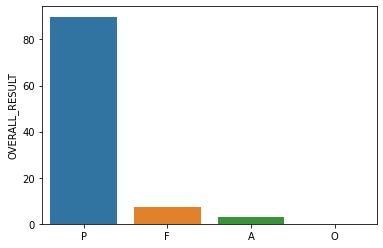

In [6]:
import seaborn as sns
y = df_all['OVERALL_RESULT']
print('Num of rows with missing values:', y.isnull().sum())
tmp = y.value_counts()*100.0/y.shape[0]
sns.barplot(x=tmp.index, y=tmp);

# features


In [7]:
# first decide unique id column
print(df_all.shape[0])
df_all[['RecordID', 'RECORD_NUM', 'VIR_CERT_NUMBER']].nunique()

193310


RecordID           193310
RECORD_NUM          31141
VIR_CERT_NUMBER    187339
dtype: int64

In [8]:
# check RecordID is in order
print(max(df_all.index)-min(df_all.index))

193309


In [9]:
# set RecordID as index
df_all['RecordID'] = df_all.RecordID.astype('string')
df_all.set_index('RecordID', inplace=True)

## vehicle features


In [10]:
# select the columns related to vehicle features
vehicle_cols = ['OVERALL_RESULT', 
                 'VIN', 'VIN_SOURCE', 'VEH_LICENSE', 'VRT_RECORD_ID',
                 'GVW_TYPE', 'GVWR', 
                 'MODEL_YEAR', 'MAKE', 'MODEL', 
                 'CYL', 'ENGINE_SIZE', 'TRANS_TYPE', 
                 'DUAL_EXHAUST', 
                 'ODOMETER', 'FUEL_TYPE', 'VEHICLE_TYPE', 
                 'EMISS_COST', 
                 'ZIP_CODE', 'CERTIFICATION',
                 'TEST_TYPE', 'VID_TEST_TYPE', 
                 'TEST_SDATE', 'TEST_EDATE']
df = df_all[vehicle_cols].copy()
df.head(2)

,OVERALL_RESULT,VIN,VIN_SOURCE,VEH_LICENSE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
2690332,P,1G4HP52K45U160372,S,368RBP,20050189,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.0,87121,C,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,P,3VWSF71K66M706988,S,843NWS,0,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.0,87108,C,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00


In [11]:
# check data types
df.dtypes.sort_values()

ENGINE_SIZE         int64
VRT_RECORD_ID       int64
GVWR                int64
MODEL_YEAR          int64
VEHICLE_TYPE        int64
ODOMETER            int64
GVW_TYPE          float64
EMISS_COST        float64
VID_TEST_TYPE      object
TEST_TYPE          object
CERTIFICATION      object
ZIP_CODE           object
FUEL_TYPE          object
OVERALL_RESULT     object
TRANS_TYPE         object
TEST_SDATE         object
CYL                object
MODEL              object
MAKE               object
VEH_LICENSE        object
VIN_SOURCE         object
VIN                object
DUAL_EXHAUST       object
TEST_EDATE         object
dtype: object

### dates


In [12]:
# check the rest
df.select_dtypes(exclude='number').head()

,OVERALL_RESULT,VIN,VIN_SOURCE,VEH_LICENSE,MAKE,MODEL,CYL,TRANS_TYPE,DUAL_EXHAUST,FUEL_TYPE,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE
RecordID,,,,,,,,,,,,,,,,
2690332,P,1G4HP52K45U160372,S,368RBP,BUICK,LESABRE,6,A,N,G,87121,C,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,P,3VWSF71K66M706988,S,843NWS,VOLKSWAGEN,JETTA,5,M,N,G,87108,C,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00
2779074,P,1FTRX17W43NA86035,S,861KMC,FORD,F150 2WD,8,A,N,G,87112,F,I,I,2013-06-18 12:45:00,2013-06-18 12:47:00
2761810,P,JTEEP21A560170542,S,GLC481,TOYOTA,HIGHLANDER 4WD,6,A,N,G,87119,C,I,I,2013-05-29 16:17:00,2013-05-29 16:18:00
2733004,F,1G1ZT52865F313274,S,JYD626,CHEVROLET,MALIBU,6,A,N,G,87111,C,I,I,2013-04-22 15:54:00,2013-04-22 15:58:00


In [13]:
# select date columns

date_cols = ['TEST_SDATE', 'TEST_EDATE']

# transform date columns

def to_datetime(df, date_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    return df

df = to_datetime(df, date_cols)
print(df[date_cols].dtypes)
df[date_cols].head()

TEST_SDATE    datetime64[ns]
TEST_EDATE    datetime64[ns]
dtype: object


,TEST_SDATE,TEST_EDATE
RecordID,,
2690332,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,2013-07-22 16:55:00,2013-07-22 16:56:00
2779074,2013-06-18 12:45:00,2013-06-18 12:47:00
2761810,2013-05-29 16:17:00,2013-05-29 16:18:00
2733004,2013-04-22 15:54:00,2013-04-22 15:58:00


In [14]:
# range of dates
print('SDATE', min(df['TEST_SDATE']),  max(df['TEST_SDATE']))
print('EDATE', min(df['TEST_EDATE']),  max(df['TEST_EDATE']))
print('missing EDATE', df['TEST_EDATE'].isnull().sum())
print('missing SDATE', df['TEST_SDATE'].isnull().sum())

SDATE 2013-01-01 14:10:00 2020-12-31 17:39:11
EDATE 2013-01-01 14:11:00 2020-12-31 17:40:36
missing EDATE 0
missing SDATE 0


In [15]:
# check whether some rows have SDATE later then EDATE
df[df['TEST_EDATE'] < df['TEST_SDATE']]

,OVERALL_RESULT,VIN,VIN_SOURCE,VEH_LICENSE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
3399779,P,KNAFE121965348914,S,KNN105,0,1.0,3000,2006,KIA,SPECTRA,4,2000,A,N,117171,G,1,20.0,87121,N,I,I,2015-08-24 08:38:00,2015-08-24 07:40:00
3726458,P,5TFDV54158X032920,S,MARIA17,0,2.0,6400,2008,TOYOTA,TUNDRA 4WD,8,5700,A,N,171208,G,3,20.0,87121,C,I,I,2016-10-31 08:43:00,2016-10-31 07:45:00


**⚠️ some attention here**

In [16]:
df.head()

,OVERALL_RESULT,VIN,VIN_SOURCE,VEH_LICENSE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE
RecordID,,,,,,,,,,,,,,,,,,,,,,,,
2690332,P,1G4HP52K45U160372,S,368RBP,20050189,1.0,3875,2005,BUICK,LESABRE,6,3800,A,N,114034,G,1,5.00,87121,C,A,A,2013-03-04 10:11:00,2013-03-04 10:14:00
2804644,P,3VWSF71K66M706988,S,843NWS,0,1.0,3250,2006,VOLKSWAGEN,JETTA,5,2500,M,N,76338,G,1,16.00,87108,C,I,I,2013-07-22 16:55:00,2013-07-22 16:56:00
2779074,P,1FTRX17W43NA86035,S,861KMC,20030160,2.0,6050,2003,FORD,F150 2WD,8,4600,A,N,104849,G,3,17.00,87112,F,I,I,2013-06-18 12:45:00,2013-06-18 12:47:00
2761810,P,JTEEP21A560170542,S,GLC481,0,1.0,5360,2006,TOYOTA,HIGHLANDER 4WD,6,3300,A,N,70130,G,4,25.00,87119,C,I,I,2013-05-29 16:17:00,2013-05-29 16:18:00
2733004,F,1G1ZT52865F313274,S,JYD626,20050256,1.0,3375,2005,CHEVROLET,MALIBU,6,3500,A,N,133251,G,1,15.89,87111,C,I,I,2013-04-22 15:54:00,2013-04-22 15:58:00


**If a vehicle has multiple records from the same date, keep latest record**



In [17]:
# it is possible that some records from the same date might have missing values
df.isnull().sum()

OVERALL_RESULT        0
VIN                   0
VIN_SOURCE            0
VEH_LICENSE         234
VRT_RECORD_ID         0
GVW_TYPE           2413
GVWR                  0
MODEL_YEAR            0
MAKE                951
MODEL               956
CYL                 982
ENGINE_SIZE           0
TRANS_TYPE          982
DUAL_EXHAUST       1133
ODOMETER              0
FUEL_TYPE          1133
VEHICLE_TYPE          0
EMISS_COST         3673
ZIP_CODE           1133
CERTIFICATION       927
TEST_TYPE            52
VID_TEST_TYPE     85320
TEST_SDATE            0
TEST_EDATE            0
dtype: int64

In [18]:
# add new column which has date but not hours of the day
df['TEST_DATE'] = df['TEST_EDATE'].dt.date

# keep the lastest record from the same date for each vehicle
df = df.loc[df.groupby(['VIN', 'TEST_DATE'])['TEST_EDATE'].idxmax(),:].copy()
df.shape

(185367, 25)

### categorical columns 

In [20]:
# choose categorical columns
df.select_dtypes(exclude='number').nunique().sort_values(ascending=True)[:10]

DUAL_EXHAUST       2
VID_TEST_TYPE      2
VIN_SOURCE         2
TEST_TYPE          2
TRANS_TYPE         2
OVERALL_RESULT     4
CERTIFICATION      5
FUEL_TYPE          7
CYL               10
MAKE              92
dtype: int64

In [21]:
# select the categorical columns
categorical_cols = df.select_dtypes(exclude='number').nunique().sort_values(ascending=True).index[:9]

df[categorical_cols].head()

,DUAL_EXHAUST,VID_TEST_TYPE,VIN_SOURCE,TEST_TYPE,TRANS_TYPE,OVERALL_RESULT,CERTIFICATION,FUEL_TYPE,CYL
RecordID,,,,,,,,,
4122772,NaN,NaN,S,I,NaN,A,NaN,NaN,NaN
4118828,N,NaN,S,I,A,F,F,G,4
3716231,N,I,S,I,A,P,C,D,4
2643540,N,I,S,I,A,P,C,G,6
3870644,N,I,M,I,A,P,C,G,8


In [22]:
# define a function for converting the categorical columns to numeric
def factorize(df, cols):
    for col in cols:
        df[col] = pd.factorize(df[col])[0]
    return df

# apply the function
df = factorize(df, categorical_cols)
df[categorical_cols].head()

,DUAL_EXHAUST,VID_TEST_TYPE,VIN_SOURCE,TEST_TYPE,TRANS_TYPE,OVERALL_RESULT,CERTIFICATION,FUEL_TYPE,CYL
RecordID,,,,,,,,,
4122772,-1,-1,0,0,-1,0,-1,-1,-1
4118828,0,-1,0,0,0,1,0,0,0
3716231,0,0,0,0,0,2,1,1,0
2643540,0,0,0,0,0,2,1,0,1
3870644,0,0,1,0,0,2,1,0,2


### strings

In [23]:
df.select_dtypes(exclude='number').head(2)

,VIN,VEH_LICENSE,MAKE,MODEL,ZIP_CODE,TEST_SDATE,TEST_EDATE,TEST_DATE
RecordID,,,,,,,,
4122772,.L6ED26T22C312858,RLRCSTR,NaN,NaN,NaN,2018-04-17 13:01:41,2018-04-17 13:02:43,2018-04-17
4118828,0BBSK5468MZ014126,389NCH,GEO,PRIZM,87047,2018-04-11 13:54:28,2018-04-11 14:01:45,2018-04-11


In [24]:
# select string columns

string_cols = ['VIN', 'VEH_LICENSE', 'MAKE', 'MODEL', 'ZIP_CODE']

# tranform string columns

def to_string(df, string_cols):
    for col in string_cols:
        df[col] = df[col].astype('string')
    return df

df = to_string(df, string_cols)
print(df[string_cols].dtypes)
df[string_cols].head()

VIN            string
VEH_LICENSE    string
MAKE           string
MODEL          string
ZIP_CODE       string
dtype: object


,VIN,VEH_LICENSE,MAKE,MODEL,ZIP_CODE
RecordID,,,,,
4122772,.L6ED26T22C312858,RLRCSTR,<NA>,<NA>,<NA>
4118828,0BBSK5468MZ014126,389NCH,GEO,PRIZM,87047
3716231,0S2RC61H045251900,NP251900,SUZUKI,AERIO,87123
2643540,0T3HN86R919053130,LPF775,TOYOTA,4RUNNER 4WD,87108
3870644,107HA182X6J111384,661TCB,DODGE,RAM 1500 2WD,87105


In [25]:
df[string_cols].isnull().sum()

VIN              0
VEH_LICENSE    107
MAKE           272
MODEL          273
ZIP_CODE       337
dtype: int64

### numeric columns


In [26]:
# numeric columns
df.select_dtypes(include='number').head()

,OVERALL_RESULT,VIN_SOURCE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE
RecordID,,,,,,,,,,,,,,,,,
4122772,0,0,0,NaN,0,0,-1,0,-1,-1,0,-1,0,NaN,-1,0,-1
4118828,1,0,910511,1.0,2625,1991,0,1600,0,0,215161,0,1,16.12,0,0,-1
3716231,2,0,20040476,1.0,3000,2004,0,2300,0,0,156888,1,1,15.00,1,0,0
2643540,2,0,20010500,1.0,4250,2001,1,3400,0,0,124227,0,4,16.00,1,0,0
3870644,2,1,0,1.0,6000,2006,2,5700,0,0,66315,0,3,25.00,1,0,0


In [27]:
# statistic summary of numeric columns
df.drop(columns=['VRT_RECORD_ID']).describe()

,OVERALL_RESULT,VIN_SOURCE,GVW_TYPE,GVWR,MODEL_YEAR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE
count,185367.000000,185367.000000,184448.000000,185367.000000,185367.000000,185367.000000,185367.000000,185367.000000,185367.000000,1.853670e+05,185367.000000,185367.000000,184095.000000,185367.000000,185367.000000,185367.000000
mean,1.922079,0.088829,1.232862,4479.413051,2003.414923,0.854651,3335.955348,0.094742,0.003792,1.094687e+05,0.028721,2.489240,20.413167,0.755987,0.024282,-0.423009
std,0.306084,0.284498,0.482909,1854.693506,76.950633,0.884181,1294.904041,0.298026,0.086106,2.171587e+05,0.249197,1.550439,7.167155,0.556007,0.154517,0.515415
min,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000e+00,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,2.000000,0.000000,1.000000,3375.000000,2002.000000,0.000000,2400.000000,0.000000,0.000000,5.318450e+04,0.000000,1.000000,17.000000,0.000000,0.000000,-1.000000
50%,2.000000,0.000000,1.000000,4450.000000,2007.000000,1.000000,3300.000000,0.000000,0.000000,9.679800e+04,0.000000,3.000000,21.000000,1.000000,0.000000,0.000000
75%,2.000000,0.000000,1.000000,5644.000000,2012.000000,1.000000,4000.000000,0.000000,0.000000,1.443455e+05,0.000000,4.000000,24.990000,1.000000,0.000000,0.000000
max,3.000000,1.000000,3.000000,10000.000000,2021.000000,9.000000,8400.000000,1.000000,1.000000,9.999999e+06,6.000000,7.000000,79.950000,4.000000,1.000000,1.000000


In [28]:
# check correlations between columns
df.corr().style.background_gradient(axis=None, cmap='coolwarm')

,OVERALL_RESULT,VIN_SOURCE,VRT_RECORD_ID,GVW_TYPE,GVWR,MODEL_YEAR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE
OVERALL_RESULT,1.000000,-0.056682,-0.018251,-0.005049,0.017808,0.253263,-0.010633,-0.004775,-0.017656,0.124406,-0.045609,0.062654,0.014410,0.006106,0.051463,-0.022959,0.044627
VIN_SOURCE,-0.056682,1.000000,-0.056650,-0.001583,-0.018601,-0.023643,0.017014,0.018369,0.076287,0.011794,0.021899,-0.014452,-0.001796,0.016447,-0.036801,0.019535,0.065203
VRT_RECORD_ID,-0.018251,-0.056650,1.000000,-0.035473,0.064370,0.011300,0.044710,0.026295,-0.005188,0.008256,0.096804,-0.010366,-0.001903,-0.053206,0.066324,0.032647,-0.150425
GVW_TYPE,-0.005049,-0.001583,-0.035473,1.000000,0.713195,-0.006028,0.504854,0.668194,-0.112581,-0.012661,0.028335,0.028953,0.494613,0.013152,-0.117399,0.010201,-0.009281
GVWR,0.017808,-0.018601,0.064370,0.713195,1.000000,0.090942,0.499923,0.668322,-0.112437,0.026611,0.042566,0.022971,0.685151,0.026730,-0.095376,0.020141,-0.180532
MODEL_YEAR,0.253263,-0.023643,0.011300,-0.006028,0.090942,1.000000,0.066652,0.084406,0.119175,0.444091,0.002234,0.162971,0.056935,0.138119,0.133161,-0.005849,0.019558
CYL,-0.010633,0.017014,0.044710,0.504854,0.499923,0.066652,1.000000,0.774592,-0.113754,0.093122,0.047149,-0.040133,0.333414,-0.000318,-0.104792,0.018646,0.043337
ENGINE_SIZE,-0.004775,0.018369,0.026295,0.668194,0.668322,0.084406,0.774592,1.000000,-0.119980,0.102415,0.055096,-0.031267,0.491857,-0.002580,-0.139701,0.020058,0.044281
TRANS_TYPE,-0.017656,0.076287,-0.005188,-0.112581,-0.112437,0.119175,-0.113754,-0.119980,1.000000,0.087116,0.038468,-0.005477,-0.074686,-0.013365,-0.011481,0.032282,0.055311
DUAL_EXHAUST,0.124406,0.011794,0.008256,-0.012661,0.026611,0.444091,0.093122,0.102415,0.087116,1.000000,0.001285,0.085685,-0.010827,0.008512,0.057642,0.001999,0.020103


**⚠️ multicolinearity**

### vehicles with multiple records

In [29]:
# before go further let's drop some columns

cols_to_drop = ['VIN_SOURCE', 'VEH_LICENSE', 'VRT_RECORD_ID']

df = df.drop(columns=cols_to_drop)

df.shape

(185367, 22)

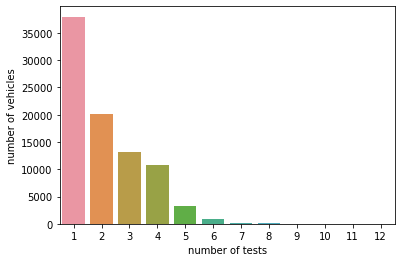

In [30]:
# how many vehicle were tested how many times
tmp = df.VIN.value_counts().sort_values()
ax = sns.countplot(x=tmp)
ax.set(ylabel='number of vehicles', xlabel='number of tests');

In [31]:
df.VIN.value_counts().value_counts()

1     37968
2     20113
3     13175
4     10824
5      3321
6       882
7       230
8        65
9        21
10        8
11        4
12        1
Name: VIN, dtype: Int64

In [32]:
# let's check a vehicle that was tested 10 times
df[df.VIN == df.VIN.value_counts().sort_values(ascending=False).index[5]]

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE
RecordID,,,,,,,,,,,,,,,,,,,,,,
2678067,2,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,148416,0,1,15.00,87108,1,0,0,2013-02-18 09:20:00,2013-02-18 09:23:00,2013-02-18
3173392,2,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,0,0,168266,0,1,16.00,87108,1,0,0,2014-12-09 08:30:00,2014-12-09 08:33:00,2014-12-09
3754347,2,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,182443,0,1,15.98,87108,1,0,0,2016-12-12 10:37:00,2016-12-12 10:39:00,2016-12-12
4342594,2,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,191653,0,1,19.95,87105,1,1,-1,2019-02-11 11:49:41,2019-02-11 11:51:25,2019-02-11
4612999,1,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,195665,0,1,20.00,87121,1,0,-1,2020-02-05 13:19:16,2020-02-05 13:22:19,2020-02-05
4623326,1,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,155691,0,1,17.25,87105,1,0,-1,2020-02-20 14:56:53,2020-02-20 15:01:45,2020-02-20
4630984,1,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,155843,0,1,12.95,87108,1,1,-1,2020-02-29 11:34:57,2020-02-29 11:40:42,2020-02-29
4637626,1,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,195881,0,1,19.95,87105,1,1,-1,2020-03-06 15:12:36,2020-03-06 15:15:12,2020-03-06
4644210,0,3VWTE29M0YM179467,1.0,3250,2000,VOLKSWAGEN,JETTA,1,2800,1,0,196032,0,1,19.95,87123,1,0,-1,2020-03-14 13:20:38,2020-03-14 13:20:38,2020-03-14


#### one entry for one vehicle


In [33]:
# keep most recent record for each vehicle

df1 = df.loc[df.groupby('VIN')['TEST_EDATE'].idxmax(),:]

# check whether each vehicle showed up in new dataframe just once

print('max numer of times a VIN showed up in new dataframe:', max(df1.VIN.value_counts()))
print('number of unique vehicles:', df1.shape[0])    


max numer of times a VIN showed up in new dataframe: 1
number of unique vehicles: 86612


In [34]:
# let's take the historical data out

df2 = df[~df.index.isin(df1.index)]

print('records that belong to historical records:', df2.shape[0])


records that belong to historical records: 98755


In [35]:
df2.head()

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE
RecordID,,,,,,,,,,,,,,,,,,,,,,
3909086,2,19UDE2F75GA006904,1.0,4023,2016,ACURA,ILX,0,2400,0,0,12431,0,1,24.99,87114,1,0,-1,2017-07-03 09:56:50,2017-07-03 09:59:40,2017-07-03
3997997,2,19UDE2F75GA006904,1.0,0,2016,ACURA,ILX,0,2400,0,0,14842,0,1,34.95,87107,1,0,0,2017-10-30 15:40:00,2017-10-30 15:44:00,2017-10-30
3080835,2,19UUA5640XA048190,1.0,3875,1998,ACURA,3.2TL,1,3200,0,0,141508,0,1,15.00,87109,2,0,0,2014-08-05 15:13:00,2014-08-05 15:18:00,2014-08-05
2711345,2,19UUA5641XA019541,1.0,3750,1999,ACURA,3.2TL,1,3200,0,0,156193,0,1,25.00,87107,1,0,0,2013-03-27 11:10:00,2013-03-27 11:12:00,2013-03-27
3539418,2,19UUA5641XA019541,1.0,3750,1999,ACURA,3.2TL,1,3200,0,0,174331,0,1,25.00,87107,0,0,0,2016-03-05 10:57:00,2016-03-05 11:00:00,2016-03-05


In [36]:
# let's peel the historical df2 like an onion into multiple dataframes according to timeline

older_records = [] # a list to collect dataframes

updated_df = df2.drop(columns=['MODEL_YEAR', 'MAKE', 'MODEL']) # values in these columns don't change for a vehicle

for i in range(11):
    print(f'getting layer {i}')
    latest = updated_df.loc[updated_df.groupby('VIN')['TEST_EDATE'].idxmax(), :]
    older_records.append(latest.reset_index())
    tmp = updated_df[~updated_df.index.isin(latest.index)]
    updated_df = tmp.copy()

getting layer 0
getting layer 1
getting layer 2
getting layer 3
getting layer 4
getting layer 5
getting layer 6
getting layer 7
getting layer 8
getting layer 9
getting layer 10


In [37]:
# merge the dataframes in older_records with df1

updated_df = df1
for index, record in enumerate(older_records):
    merged_df = pd.merge(updated_df, record, how='left', on='VIN', suffixes=(None, '_'+str(index+1)))
    updated_df = merged_df.copy()  

print(updated_df.shape)

updated_df.head()

(86612, 231)


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE,RecordID,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,EMISS_COST_1,ZIP_CODE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,TEST_DATE_1,RecordID_2,OVERALL_RESULT_2,GVW_TYPE_2,GVWR_2,CYL_2,ENGINE_SIZE_2,TRANS_TYPE_2,DUAL_EXHAUST_2,ODOMETER_2,FUEL_TYPE_2,VEHICLE_TYPE_2,EMISS_COST_2,ZIP_CODE_2,CERTIFICATION_2,TEST_TYPE_2,VID_TEST_TYPE_2,TEST_SDATE_2,TEST_EDATE_2,TEST_DATE_2,RecordID_3,OVERALL_RESULT_3,GVW_TYPE_3,GVWR_3,CYL_3,ENGINE_SIZE_3,TRANS_TYPE_3,DUAL_EXHAUST_3,ODOMETER_3,FUEL_TYPE_3,VEHICLE_TYPE_3,EMISS_COST_3,ZIP_CODE_3,CERTIFICATION_3,TEST_TYPE_3,VID_TEST_TYPE_3,TEST_SDATE_3,TEST_EDATE_3,TEST_DATE_3,RecordID_4,OVERALL_RESULT_4,GVW_TYPE_4,GVWR_4,CYL_4,ENGINE_SIZE_4,TRANS_TYPE_4,DUAL_EXHAUST_4,ODOMETER_4,FUEL_TYPE_4,VEHICLE_TYPE_4,EMISS_COST_4,ZIP_CODE_4,CERTIFICATION_4,TEST_TYPE_4,VID_TEST_TYPE_4,TEST_SDATE_4,TEST_EDATE_4,TEST_DATE_4,RecordID_5,OVERALL_RESULT_5,GVW_TYPE_5,GVWR_5,CYL_5,ENGINE_SIZE_5,TRANS_TYPE_5,DUAL_EXHAUST_5,ODOMETER_5,FUEL_TYPE_5,VEHICLE_TYPE_5,EMISS_COST_5,ZIP_CODE_5,CERTIFICATION_5,TEST_TYPE_5,VID_TEST_TYPE_5,TEST_SDATE_5,TEST_EDATE_5,TEST_DATE_5,RecordID_6,OVERALL_RESULT_6,GVW_TYPE_6,GVWR_6,CYL_6,ENGINE_SIZE_6,TRANS_TYPE_6,DUAL_EXHAUST_6,ODOMETER_6,FUEL_TYPE_6,VEHICLE_TYPE_6,EMISS_COST_6,ZIP_CODE_6,CERTIFICATION_6,TEST_TYPE_6,VID_TEST_TYPE_6,TEST_SDATE_6,TEST_EDATE_6,TEST_DATE_6,RecordID_7,OVERALL_RESULT_7,GVW_TYPE_7,GVWR_7,CYL_7,ENGINE_SIZE_7,TRANS_TYPE_7,DUAL_EXHAUST_7,ODOMETER_7,FUEL_TYPE_7,VEHICLE_TYPE_7,EMISS_COST_7,ZIP_CODE_7,CERTIFICATION_7,TEST_TYPE_7,VID_TEST_TYPE_7,TEST_SDATE_7,TEST_EDATE_7,TEST_DATE_7,RecordID_8,OVERALL_RESULT_8,GVW_TYPE_8,GVWR_8,CYL_8,ENGINE_SIZE_8,TRANS_TYPE_8,DUAL_EXHAUST_8,ODOMETER_8,FUEL_TYPE_8,VEHICLE_TYPE_8,EMISS_COST_8,ZIP_CODE_8,CERTIFICATION_8,TEST_TYPE_8,VID_TEST_TYPE_8,TEST_SDATE_8,TEST_EDATE_8,TEST_DATE_8,RecordID_9,OVERALL_RESULT_9,GVW_TYPE_9,GVWR_9,CYL_9,ENGINE_SIZE_9,TRANS_TYPE_9,DUAL_EXHAUST_9,ODOMETER_9,FUEL_TYPE_9,VEHICLE_TYPE_9,EMISS_COST_9,ZIP_CODE_9,CERTIFICATION_9,TEST_TYPE_9,VID_TEST_TYPE_9,TEST_SDATE_9,TEST_EDATE_9,TEST_DATE_9,RecordID_10,OVERALL_RESULT_10,GVW_TYPE_10,GVWR_10,CYL_10,ENGINE_SIZE_10,TRANS_TYPE_10,DUAL_EXHAUST_10,ODOMETER_10,FUEL_TYPE_10,VEHICLE_TYPE_10,EMISS_COST_10,ZIP_CODE_10,CERTIFICATION_10,TEST_TYPE_10,VID_TEST_TYPE_10,TEST_SDATE_10,TEST_EDATE_10,TEST_DATE_10,RecordID_11,OVERALL_RESULT_11,GVW_TYPE_11,GVWR_11,CYL_11,ENGINE_SIZE_11,TRANS_TYPE_11,DUAL_EXHAUST_11,ODOMETER_11,FUEL_TYPE_11,VEHICLE_TYPE_11,EMISS_COST_11,ZIP_CODE_11,CERTIFICATION_11,TEST_TYPE_11,VID_TEST_TYPE_11,TEST_SDATE_11,TEST_EDATE_11,TEST_DATE_11
0,0,.L6ED26T22C312858,NaN,0,0,<NA>,<NA>,-1,0,-1,-1,0,-1,0,NaN,<NA>,-1,0,-1,2018-04-17 13:01:41,2018-04-17 13:02:43,2018-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN
1,1,0BBSK5468MZ014126,1.0,2625,1991,GEO,PRIZM,0,1600,0,0,215161,0,1,16.12,87047,0,0,-1,2018-04-11 13:54:28,2018-04-11 14:01:45,2018-04-11,NaN,NaN,NaN,NaN,N

In [38]:
# let's check out the vehicle that was tested for 11 times in last 7 years
updated_df[~updated_df.RecordID_11.isnull()]

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE,RecordID,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,EMISS_COST_1,ZIP_CODE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,TEST_DATE_1,RecordID_2,OVERALL_RESULT_2,GVW_TYPE_2,GVWR_2,CYL_2,ENGINE_SIZE_2,TRANS_TYPE_2,DUAL_EXHAUST_2,ODOMETER_2,FUEL_TYPE_2,VEHICLE_TYPE_2,EMISS_COST_2,ZIP_CODE_2,CERTIFICATION_2,TEST_TYPE_2,VID_TEST_TYPE_2,TEST_SDATE_2,TEST_EDATE_2,TEST_DATE_2,RecordID_3,OVERALL_RESULT_3,GVW_TYPE_3,GVWR_3,CYL_3,ENGINE_SIZE_3,TRANS_TYPE_3,DUAL_EXHAUST_3,ODOMETER_3,FUEL_TYPE_3,VEHICLE_TYPE_3,EMISS_COST_3,ZIP_CODE_3,CERTIFICATION_3,TEST_TYPE_3,VID_TEST_TYPE_3,TEST_SDATE_3,TEST_EDATE_3,TEST_DATE_3,RecordID_4,OVERALL_RESULT_4,GVW_TYPE_4,GVWR_4,CYL_4,ENGINE_SIZE_4,TRANS_TYPE_4,DUAL_EXHAUST_4,ODOMETER_4,FUEL_TYPE_4,VEHICLE_TYPE_4,EMISS_COST_4,ZIP_CODE_4,CERTIFICATION_4,TEST_TYPE_4,VID_TEST_TYPE_4,TEST_SDATE_4,TEST_EDATE_4,TEST_DATE_4,RecordID_5,OVERALL_RESULT_5,GVW_TYPE_5,GVWR_5,CYL_5,ENGINE_SIZE_5,TRANS_TYPE_5,DUAL_EXHAUST_5,ODOMETER_5,FUEL_TYPE_5,VEHICLE_TYPE_5,EMISS_COST_5,ZIP_CODE_5,CERTIFICATION_5,TEST_TYPE_5,VID_TEST_TYPE_5,TEST_SDATE_5,TEST_EDATE_5,TEST_DATE_5,RecordID_6,OVERALL_RESULT_6,GVW_TYPE_6,GVWR_6,CYL_6,ENGINE_SIZE_6,TRANS_TYPE_6,DUAL_EXHAUST_6,ODOMETER_6,FUEL_TYPE_6,VEHICLE_TYPE_6,EMISS_COST_6,ZIP_CODE_6,CERTIFICATION_6,TEST_TYPE_6,VID_TEST_TYPE_6,TEST_SDATE_6,TEST_EDATE_6,TEST_DATE_6,RecordID_7,OVERALL_RESULT_7,GVW_TYPE_7,GVWR_7,CYL_7,ENGINE_SIZE_7,TRANS_TYPE_7,DUAL_EXHAUST_7,ODOMETER_7,FUEL_TYPE_7,VEHICLE_TYPE_7,EMISS_COST_7,ZIP_CODE_7,CERTIFICATION_7,TEST_TYPE_7,VID_TEST_TYPE_7,TEST_SDATE_7,TEST_EDATE_7,TEST_DATE_7,RecordID_8,OVERALL_RESULT_8,GVW_TYPE_8,GVWR_8,CYL_8,ENGINE_SIZE_8,TRANS_TYPE_8,DUAL_EXHAUST_8,ODOMETER_8,FUEL_TYPE_8,VEHICLE_TYPE_8,EMISS_COST_8,ZIP_CODE_8,CERTIFICATION_8,TEST_TYPE_8,VID_TEST_TYPE_8,TEST_SDATE_8,TEST_EDATE_8,TEST_DATE_8,RecordID_9,OVERALL_RESULT_9,GVW_TYPE_9,GVWR_9,CYL_9,ENGINE_SIZE_9,TRANS_TYPE_9,DUAL_EXHAUST_9,ODOMETER_9,FUEL_TYPE_9,VEHICLE_TYPE_9,EMISS_COST_9,ZIP_CODE_9,CERTIFICATION_9,TEST_TYPE_9,VID_TEST_TYPE_9,TEST_SDATE_9,TEST_EDATE_9,TEST_DATE_9,RecordID_10,OVERALL_RESULT_10,GVW_TYPE_10,GVWR_10,CYL_10,ENGINE_SIZE_10,TRANS_TYPE_10,DUAL_EXHAUST_10,ODOMETER_10,FUEL_TYPE_10,VEHICLE_TYPE_10,EMISS_COST_10,ZIP_CODE_10,CERTIFICATION_10,TEST_TYPE_10,VID_TEST_TYPE_10,TEST_SDATE_10,TEST_EDATE_10,TEST_DATE_10,RecordID_11,OVERALL_RESULT_11,GVW_TYPE_11,GVWR_11,CYL_11,ENGINE_SIZE_11,TRANS_TYPE_11,DUAL_EXHAUST_11,ODOMETER_11,FUEL_TYPE_11,VEHICLE_TYPE_11,EMISS_COST_11,ZIP_CODE_11,CERTIFICATION_11,TEST_TYPE_11,VID_TEST_TYPE_11,TEST_SDATE_11,TEST_EDATE_11,TEST_DATE_11
85746,2,YS3AL35L6K3021221,1.0,3860,1989,SAAB,900 TURBO,0,2000,1,0,233088,0,1,12.0,87105,1,0,-1,2020-07-25 16:05:04,2020-07-25 16:12:16,2020-07-25,4698198,1.0,1.0,3860.0,0.0,2000.0,1.0,0.0,232161.0,0.0,1.0,12.0,87105,1.0,1.0,-1.0,2020-06-13 10:56:40,2020-06-13 11:06:29,2020-06-13,4678796,1.0,1.0,3860.0,0.0,2000.0,1.0,0.0,231667.0,0.0,1.0,12.0,87105,1.0,0.0,-1.0,2020-05-22 10:51:51,2020-05-22 11:01:19,2020-05-22,4678763,1.0,NaN,3250.0,0.0,2000.0,1.0,0.0,231616.0,0.0,1.0,12.0,87105,1.0,1.0,-1.0,2020-05-21 14:36:00,2020-05-21 14:43:27,2020-05-21,4670588,1.0,1.0,3250.0,0.0,2000.0,1.0,0.0,231325.0,0.0,1.0,25.0,87105,1.0,0.0,-1.0,2020-05-09 11:14:00,2020-05-09 11:23:53,2020-05-09,4660829,1.0,1.0,3250.0,0.0,2000.0,1.0,0.0,230910.0,0.0,1.0,15.0,87105,1.0,1.0,-1.0,2020-04-20 12:52:41,2020-04-20 13:02:51,2020-04-20,4652391,0.0,1.0,3250.0,0.0,2000.0,1.0,0.0,230404.0,0.0,1.0,18.0,87105,1.0,1.0,-1.0,2020-03-30 11:27:54,2020-03-30 11:27:54,2020-03-30,4650736,1.0,1.0,3250.0,0.0,2000.0,1.0,0.0,230258.0,0.0,1.0,18.0,87105,1.0,0.0,-1.0,2020-03-25 11:58:33,2020-03-25 12:08:16,2020-03-25,4103735,2.0,1.0,3250.0,0.0,2000.0,1.0,0.0,21

#### all records with possible previous testing records


In [39]:
df.head()

,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE
RecordID,,,,,,,,,,,,,,,,,,,,,,
4122772,0,.L6ED26T22C312858,NaN,0,0,<NA>,<NA>,-1,0,-1,-1,0,-1,0,NaN,<NA>,-1,0,-1,2018-04-17 13:01:41,2018-04-17 13:02:43,2018-04-17
4118828,1,0BBSK5468MZ014126,1.0,2625,1991,GEO,PRIZM,0,1600,0,0,215161,0,1,16.12,87047,0,0,-1,2018-04-11 13:54:28,2018-04-11 14:01:45,2018-04-11
3716231,2,0S2RC61H045251900,1.0,3000,2004,SUZUKI,AERIO,0,2300,0,0,156888,1,1,15.00,87123,1,0,0,2016-10-15 15:09:00,2016-10-15 15:13:00,2016-10-15
2643540,2,0T3HN86R919053130,1.0,4250,2001,TOYOTA,4RUNNER 4WD,1,3400,0,0,124227,0,4,16.00,87108,1,0,0,2013-01-03 16:45:00,2013-01-03 16:47:00,2013-01-03
3870644,2,107HA182X6J111384,1.0,6000,2006,DODGE,RAM 1500 2WD,2,5700,0,0,66315,0,3,25.00,87105,1,0,0,2017-05-13 14:56:00,2017-05-13 14:57:00,2017-05-13


In [132]:
# all the records where vehicles didn't receive test before
df1 = df.loc[df.groupby('VIN')['TEST_EDATE'].idxmin(),:]
df1.shape

(86612, 22)

In [133]:
# records whose vehicle has historical data
tmp = df.VIN.value_counts()
df2 = df[df.VIN.isin(tmp[tmp>1].index)]
df2.shape

(147399, 22)

In [134]:
# merge historical data once on VIN
df3 = df2.reset_index()
df4 = df2.drop(columns=['MODEL_YEAR', 'MAKE', 'MODEL']).reset_index()
merge = pd.merge(df3, df4, how='left', on='VIN', suffixes=(None, '_1'))

print(merge.shape)

(505547, 42)


In [135]:
# add a helper column
merge['DELTA'] = merge['TEST_DATE']-merge['TEST_DATE_1']
print(merge.shape)

# only keep the entries where TEST_DATE_1 is earlier than TEST_DATE
merge = merge[merge.DELTA > timedelta(days=0)]
merge.reset_index(drop=True, inplace=True)
print(merge.shape)

merge.DELTA.describe()

(505547, 43)
(179074, 43)


count                         179074
mean     974 days 08:01:37.300557328
std      607 days 05:18:51.809799160
min                  1 days 00:00:00
25%                693 days 00:00:00
50%                768 days 00:00:00
75%               1453 days 00:00:00
max               2918 days 00:00:00
Name: DELTA, dtype: object

In [136]:
# keep the rows whose DELTA is > 90, meaning vehicle's last check up was at least 90 days earlier than this time

# print(merge.shape)
# merge = merge[merge.DELTA > timedelta(days=90)]
# merge.reset_index(inplace=True)
# print(merge.shape)

In [137]:
# for each RecordID only keep most recent record as previous testing record
df_hist = merge.loc[merge.groupby('RecordID')['DELTA'].idxmin(), :]
df_hist.set_index('RecordID', inplace=True)
print(df_hist.shape)
df_hist.head(5)

(98755, 42)


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE,RecordID_1,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,EMISS_COST_1,ZIP_CODE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,TEST_DATE_1,DELTA
RecordID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2644403,2,YS3ED48E613016942,1.0,3875,2001,SAAB,9-5,0,2300,0,0,180178,0,1,10.0,87047,2,1,1,2013-01-04 14:23:00,2013-01-04 14:26:00,2013-01-04,2642716,1,1.0,3875,0,2300,0,0,180069,0,1,21.00,87047,2,0,0,2013-01-02 09:09:00,2013-01-02 09:14:00,2013-01-02,2 days
2644699,2,WVWNA23B4YE370152,1.0,3500,2000,VOLKSWAGEN,PASSAT,0,1800,0,0,137787,0,2,13.0,87112,1,0,0,2013-01-04 13:35:00,2013-01-04 13:38:00,2013-01-04,2643856,0,1.0,3500,0,1800,0,0,137721,0,2,NaN,87112,0,0,-1,2013-01-03 17:13:00,2013-01-03 17:13:00,2013-01-03,1 days
2645007,1,JM1BG2264N0510148,1.0,2750,1992,MAZDA,PROTEGE,0,1800,1,0,199451,0,1,17.0,87113,0,0,0,2013-01-05 13:55:00,2013-01-05 14:02:00,2013-01-05,2643213,1,1.0,2750,0,1800,1,0,199313,0,1,10.00,87113,0,0,0,2013-01-03 14:13:00,2013-01-03 14:21:00,2013-01-03,2 days
2646101,2,1FAFP53U75A214119,1.0,3625,2005,FORD,TAURUS,1,3000,0,0,146521,0,1,21.0,87110,1,0,0,2013-01-07 11:31:00,2013-01-07 11:34:00,2013-01-07,2643995,1,1.0,3625,1,3000,0,0,149445,0,1,24.99,87110,1,0,0,2013-01-04 12:58:00,2013-01-04 13:02:00,2013-01-04,3 days
2646270,1,JM1BG2264N0510148,1.0,2750,1992,MAZDA,PROTEGE,0,1800,1,0,199511,0,1,10.0,87113,0,1,1,2013-01-07 13:20:00,2013-01-07 13:27:00,2013-01-07,2645007,1,1.0,2750,0,1800,1,0,199451,0,1,17.00,87113,0,0,0,2013-01-05 13:55:00,2013-01-05 14:02:00,2013-01-05,2 days


In [143]:
# check if the row numbers make sense
assert df_hist.index.nunique() == df2.shape[0] - df2.VIN.nunique()

In [150]:
# stack df1 and df_hist
updated_df2 = pd.concat([df1, df_hist])
print(updated_df2.shape)
updated_df2.sort_index().tail()

(185367, 42)


,OVERALL_RESULT,VIN,GVW_TYPE,GVWR,MODEL_YEAR,MAKE,MODEL,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,ZIP_CODE,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,TEST_SDATE,TEST_EDATE,TEST_DATE,RecordID_1,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,EMISS_COST_1,ZIP_CODE_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1,TEST_SDATE_1,TEST_EDATE_1,TEST_DATE_1,DELTA
RecordID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4843546,2,2T3J1RFV5LC094886,1.0,4705,2020,TOYOTA,RAV4,0,2500,0,0,14070,0,4,25.00,87105,1,0,-1,2020-12-31 16:28:39,2020-12-31 16:29:59,2020-12-31,4835394,2.0,1.0,4705.0,0.0,2500.0,0.0,0.0,13410.0,0.0,4.0,25.00,87105,1.0,0.0,-1.0,2020-12-17 10:59:01,2020-12-17 11:01:26,2020-12-17,14 days
4843554,2,1G3NL52F74C169657,1.0,3250,2004,OLDSMOBILE,ALERO,0,2200,0,0,120430,0,1,17.26,87123,1,0,-1,2020-12-31 16:34:16,2020-12-31 16:38:05,2020-12-31,3994340,2.0,1.0,3250.0,0.0,2200.0,0.0,0.0,84307.0,0.0,1.0,16.12,87123,1.0,0.0,-1.0,2017-10-25 11:09:37,2017-10-25 11:13:54,2017-10-25,1163 days
4843592,2,KMHDU46D88U315460,1.0,3125,2008,HYUNDAI,ELANTRA,0,2000,1,0,153137,0,1,22.00,87102,1,0,-1,2020-12-31 17:39:11,2020-12-31 17:40:36,2020-12-31,4638360,2.0,1.0,3125.0,0.0,2000.0,1.0,0.0,144535.0,0.0,1.0,20.00,87121,1.0,0.0,-1.0,2020-03-07 12:53:20,2020-03-07 12:54:10,2020-03-07,299 days
4844491,2,3GNEK13T22G185380,2.0,7000,2002,CHEVROLET,AVALANCHE 4WD,2,5300,0,0,0,0,3,20.00,87105,2,0,-1,2020-12-29 14:19:52,2020-12-29 14:22:34,2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaT,NaT,NaN,NaT
4844706,2,1HGCG56612A017292,1.0,4080,2002,HONDA,ACCORD,0,2300,0,0,139330,0,1,40.00,87108,2,0,-1,2020-12-31 16:13:15,2020-12-31 16:18:53,2020-12-31,4049454,2.0,1.0,3250.0,0.0,2300.0,0.0,0.0,124072.0,0.0,1.0,21.00,87110,2.0,0.0,-1.0,2018-01-17 12:29:55,2018-01-17 12:32:27,2018-01-17,1079 days


In [151]:
updated_df2.corr().style.background_gradient(axis=None, cmap='coolwarm')

,OVERALL_RESULT,GVW_TYPE,GVWR,MODEL_YEAR,CYL,ENGINE_SIZE,TRANS_TYPE,DUAL_EXHAUST,ODOMETER,FUEL_TYPE,VEHICLE_TYPE,EMISS_COST,CERTIFICATION,TEST_TYPE,VID_TEST_TYPE,OVERALL_RESULT_1,GVW_TYPE_1,GVWR_1,CYL_1,ENGINE_SIZE_1,TRANS_TYPE_1,DUAL_EXHAUST_1,ODOMETER_1,FUEL_TYPE_1,VEHICLE_TYPE_1,EMISS_COST_1,CERTIFICATION_1,TEST_TYPE_1,VID_TEST_TYPE_1
OVERALL_RESULT,1.000000,-0.005049,0.017808,0.253263,-0.010633,-0.004775,-0.017656,0.124406,-0.045609,0.062654,0.014410,0.006106,0.051463,-0.022959,0.044627,0.132779,-0.004088,-0.007591,-0.023968,-0.021906,-0.050847,-0.004172,-0.040138,0.014717,-0.000183,0.031262,0.021091,-0.051596,-0.000203
GVW_TYPE,-0.005049,1.000000,0.713195,-0.006028,0.504854,0.668194,-0.112581,-0.012661,0.028335,0.028953,0.494613,0.013152,-0.117399,0.010201,-0.009281,-0.009444,0.936776,0.673814,0.511648,0.668308,-0.115375,-0.005179,0.035335,0.001767,0.489602,0.010609,-0.148909,0.006337,-0.012393
GVWR,0.017808,0.713195,1.000000,0.090942,0.499923,0.668322,-0.112437,0.026611,0.042566,0.022971,0.685151,0.026730,-0.095376,0.020141,-0.180532,-0.004515,0.698239,0.859198,0.518915,0.686079,-0.132678,-0.007698,0.038744,-0.010410,0.678221,0.025969,-0.133747,0.012674,-0.111155
MODEL_YEAR,0.253263,-0.006028,0.090942,1.000000,0.066652,0.084406,0.119175,0.444091,0.002234,0.162971,0.056935,0.138119,0.133161,-0.005849,0.019558,0.021610,-0.000221,-0.006211,-0.012319,-0.015506,-0.031011,0.009018,-0.020833,0.007099,-0.007066,0.022632,0.028112,-0.011607,-0.026641
CYL,-0.010633,0.504854,0.499923,0.066652,1.000000,0.774592,-0.113754,0.093122,0.047149,-0.040133,0.333414,-0.000318,-0.104792,0.018646,0.043337,-0.027696,0.507286,0.499797,0.944680,0.767169,-0.141031,0.052398,0.040966,-0.056982,0.338100,0.001599,-0.126290,0.015122,0.018199
ENGINE_SIZE,-0.004775,0.668194,0.668322,0.084406,0.774592,1.000000,-0.119980,0.102415,0.055096,-0.031267,0.491857,-0.002580,-0.139701,0.020058,0.044281,-0.026433,0.664063,0.661030,0.769572,0.983023,-0.147492,0.059234,0.050715,-0.061291,0.493921,-0.003905,-0.169949,0.015553,0.019663
TRANS_TYPE,-0.017656,-0.112581,-0.112437,0.119175,-0.113754,-0.119980,1.000000,0.087116,0.038468,-0.005477,-0.074686,-0.013365,-0.011481,0.032282,0.055311,-0.059668,-0.116260,-0.111632,-0.141697,-0.148230,0.921186,0.020281,0.035414,-0.029934,-0.076460,-0.016541,-0.031357,0.034134,0.024308
DUAL_EXHAUST,0.124406,-0.012661,0.026611,0.444091,0.093122,0.102415,0.087116,1.000000,0.001285,0.085685,-0.010827,0.008512,0.057642,0.001999,0.020103,-0.007403,-0.010479,-0.022270,0.054246,0.056693,0.021583,0.146958,-0.004493,-0.003892,-0.041560,0.006031,0.010589,0.008453,-0.004831
ODOMETER,-0.045609,0.028335,0.042566,0.002234,0.047149,0.055096,0.038468,0.001285,1.000000,-0.010461,0.035470,-0.041278,-0.038545,0.026404,0.004750,-0.042296,0.028815,0.046651,0.035780,0.044967,0.027714,-0.008120,0.226180,-0.011284,0.039411,-0.040879,-0.027219,0.023199,0.003374
FUEL_TYPE,0.062654,0.028953,0.022971,0.162971,-0.040133,-0.031267,-0.005477,0.085685,-0.010461,1.000000,-0.000205,-0.005359,0.063976,-0.011527,0.007187,0.016055,-0.003762,-0.022116,-0.065717,-0.070529,-0.030946,-0.000196,-0.016956,0.816404,-0.033841,0.001870,0.039705,-0.011723,-0.000451


## emission test features

In [22]:
# columns related to tests started with E_
etest_cols = ['RECORD_NUM', 'VIR_CERT_NUMBER', 'STATION_NUM', 'ANALYZER_NUM', 'INSPECTOR_NUM',
              'ESC', 'E_TEST_SEQUENCE', 'E_PRECOND_PROCEDURE', 'E_HIGH_DCF', 'E_HIGH_RPM', 
              'E_HIGH_CO2', 'E_HIGH_O2', 'E_HIGH_HC', 'E_HIGH_HC_DCF', 'E_HIGH_HC_LIMIT', 'E_HIGH_CO', 
              'E_HIGH_CO_DCF', 'E_HIGH_CO_LIMIT', 'E_IDLE_DCF', 'E_IDLE_RPM', 'E_IDLE_CO2', 'E_IDLE_O2', 
              'E_IDLE_HC', 'E_IDLE_HC_DCF', 'E_IDLE_HC_LIMIT', 'E_IDLE_CO', 'E_IDLE_CO_DCF', 'E_IDLE_CO_LIMIT', 
              'E_HIGH_DCF_2', 'E_HIGH_RPM_2', 'E_HIGH_CO2_2', 'E_HIGH_O2_2', 'E_HIGH_HC_2', 'E_HIGH_HC_DCF_2', 
              'E_HIGH_CO_2', 'E_HIGH_CO_DCF_2', 'E_IDLE_DCF_2', 'E_IDLE_RPM_2', 'E_IDLE_CO2_2', 'E_IDLE_O2_2', 
              'E_IDLE_HC_2', 'E_IDLE_HC_DCF_2', 'E_IDLE_CO_2', 'E_IDLE_CO_DCF_2', 'E_RESULT_STRING']

## columns related to visual tests



In [23]:
# columns related to visual inspectation
vtest_cols = ['RecordID',
              'V_SMOKE1', 'V_SMOKE2', 
               'V_GASCAP', 'V_CAT', 
               'V_RESULT', 
               'KOEO_RESULT', 'KOER_RESULT']

## columns related to OBDII tests



In [24]:
# columns related to OBDII tests
otest_cols = ['RecordID',
              'OBD_RDY_MISFIRE', 'OBD_RDY_FUEL', 'OBD_RDY_COMPONENT', 'OBD_RDY_CAT', 'OBD_RDY_CAT_HEATED', 
               'OBD_RDY_EVAP', 'OBD_RDY_SEC_AIR', 'OBD_RDY_AIR_COND', 'OBD_RDY_O2_SENSOR', 'OBD_RDY_O2_HEATER', 
               'OBD_RDY_EGR', 'OBD_RDY_RESULT', 'OBD_PID', 'OBD_PCM_ID', 'OBD_VIN', 'OBD_FLT_CODES', 'OBD_FLT_RESULT', 
               'OBD_MIL_STATUS', 'OBD_RESULT', 'OBDII_AFFECT_OVERALL',
               'ONLINE_STATUS', 'OFFLINE_REASON_CODE', 'ABORT_CODE', 'SOFTWARE_VERSION', 'INSP_COMMENTS']

## columns related to repairments



In [25]:
# columns related to repairments
repair_cols = ['RecordID',
               'R_TOTAL_COST', 
                'R_EGR', 'R_ELECTRICAL', 'R_EVAP_CONTROL', 'R_EXHAUST', 
                'R_IGNITION', 'R_INTAKE', 'R_ENGINE', 'R_PCV', 'R_OTHER', 
                'SentToWW', 'ABORT_CODE_OTHER_DESC', 
                'E_HIGH_CO_RESULT', 'E_HIGH_HC_RESULT', 
                'E_IDLE_CO_RESULT', 'E_IDLE_HC_RESULT', 
                'MECHANIC_LAST_NAME', 'MECHANIC_FIRST_NAME', 'MECHANIC_MIDDLE_INIT', 
                'ENGINE_SIZE_ORIG', 'FAILED_IDLE_RPM', 'SENTTOVID', 
                'Station_License_Number', 'Analyzer_Number', 
                'Insert_DateTime']